In [28]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
import random as rand
from tqdm import tqdm
from scipy.optimize import curve_fit
import scipy.stats as stat


In [2]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [3]:
#Defining a basic power law function to fit to our wave relations r^2:
def func_powerlaw(x, a, m):
    return m*x**a

In [4]:
#Defining a basic power law function to fit to our wave relations r^2:
def func_powerlaw_simple(x, a):
    return x**a

In [5]:
#To consolodate all the wave dataframes in a set, use the following function: 
#INPUT: Sorted list of all wave dataframe csv locations:
#Option to save the DF as a csv in the relevant location is given, default is False
#OUTPUT: A dataframe containing all of the csv wave DFs in the path list

def consolidate_waves(WAVE_DF_PATHS, save_DF = False):
    
    wave_collect = []

    for wave_df_path in tqdm(WAVE_DF_PATHS):
        img_id = int(wave_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        wave_df = pd.read_csv(wave_df_path, converters={"wave_centroid": read_tuple_list}) #Open the wave_DF from step4 analysis
        wave_df = wave_df[wave_df.columns.drop(list(wave_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        track_ids = wave_df['clTrackID'].values #Get the collective track values in the wave
        wave_df['wave_ID'] = [str(img_id) + '-' + str(i) for i in track_ids] #Build a list of unique wave IDs from the image number and clTrack number they belong to
        wave_df['image_ID'] = [img_id for i in range(len(wave_df))]
        wave_collect.append(wave_df)
    
    wave_df_collected = pd.concat(wave_collect, ignore_index=True)
    
    if save_DF:
        wave_df_collected.to_csv(WAVE_DF_PATHS[0].parent / 'combined_wave_DF.csv', index=False)
        
    return wave_df_collected

In [6]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
base_path = Path.cwd().parent / 'Data Sets/2024_02_15_sod-catalase'
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

wave_dataframe_paths = sorted(analysis_output_destination.glob('*_wave_df.csv'), key=lambda x: x.stem.split('_')[0])


In [7]:
wave_con_df = consolidate_waves(wave_dataframe_paths)
wave_con_df['real_time'] = wave_con_df['rel_time'] * 5.0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 544.29it/s]


In [15]:
#collect control and sod-catalase wave max sizes: 

sod_cat_collect = []
control_collect = []


for wid, wave in wave_con_df.groupby('wave_ID'):
    if wave.drug_name.values[0] == 'sod-catalase':
        sod_cat_collect.append(wave.circle_radius.max())
    else:
        control_collect.append(wave.circle_radius.max())
                               

In [20]:
sod_cata_max_DF = pd.DataFrame(sod_cat_collect, columns=['max_wave_size'])
sod_cata_max_DF['drug'] = 'sod-catalase'

In [22]:
control_max_DF = pd.DataFrame(control_collect, columns=['max_wave_size'])
control_max_DF['drug'] = 'control'

In [23]:
combo_cond_DF = pd.concat([control_max_DF, sod_cata_max_DF], ignore_index=True)


In [34]:
#Running the ttest between the wt and drug mean alpha catagories: 
stat.ttest_ind(control_collect, sod_cat_collect, equal_var=False)


TtestResult(statistic=-1.414917295116973, pvalue=0.15980411115198753, df=114.60608981906357)

In [52]:
#Common formatting:
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})


/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

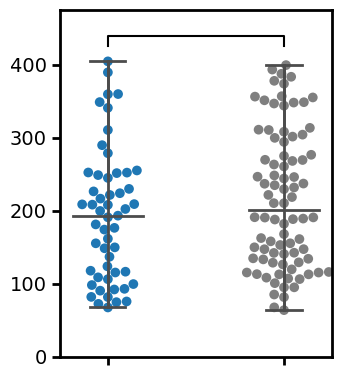

In [51]:
#Next are key wave analysis functions:

#Print out figure 2e: 
fig, ax = plt.subplots(figsize=(3.5,4.5))
sns.boxplot(data=combo_cond_DF, x='drug', y='max_wave_size', palette=[sns.color_palette()[7],sns.color_palette()[7]],  width=0.001, ax=ax, zorder=1000)
sns.boxplot(data=combo_cond_DF, x='drug', y='max_wave_size', palette=[sns.color_palette()[7],sns.color_palette()[7]],  showbox=False, width=0.4, ax=ax, zorder=1000)
sns.swarmplot(data=combo_cond_DF, x='drug', y='max_wave_size', palette=[sns.color_palette()[0],sns.color_palette()[7]], size=7, ax=ax, zorder=-1)
ax.tick_params(direction='out', width=2.0, labelsize=14)
#plt.ylim(0,50000)
plt.xlabel('')
plt.xticks([0,1],['',''])
plt.ylabel('')

# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 425, 15, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "", ha='center', va='bottom', color=col)
plt.ylim(0,475)
plt.savefig('fig3-normal-v-sod-catalase-max_wave_size.png', dpi=300, bbox_inches='tight')

In [58]:
print("Number of Waves SOD/cata: {}".format(len(sod_cat_collect)))
print("Volunteer IDs: {}".format(wave_con_df[wave_con_df['drug_name'] == 'sod-catalase'].volunteer_ID.unique()))

Number of Waves SOD/cata: 84
Volunteer IDs: [25 24 23]


In [67]:

print("Number of Waves control: {}".format(len(control_collect)))
print("Volunteer IDs: {}".format(wave_con_df[wave_con_df['drug_name'].isnull()].volunteer_ID.unique()))

Number of Waves control: 53
Volunteer IDs: [23 25 24]
